<h1 align='center'>Transformación y Selección de variables</h1>

In [90]:
%load_ext autoreload
%autoreload 2
# Gestion de rutas
import utils.paths as path
# Importacion de librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import requests
import os
import re
# Directorio de los datos crudos / raw data
raw_data_dir = path.make_dir_function(['datasets', 'raw'])
proc_data_dir = path.make_dir_function(['datasets', 'processed'])
inte_data_dir = path.make_dir_function(['datasets', 'interim'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Usando la data provicional | Lectura del dataset
noise_pollution = pd.read_parquet(inte_data_dir('noise_pollution.parquet'))

In [92]:
def replace_negatives_ones(df, cols):
    for col in cols:
        df[col] = df[col].replace(-1,1)
    return df

In [93]:
noise_pollution_v1 = replace_negatives_ones(noise_pollution, noise_pollution.loc[::,'small_sounding_engine':'unknown_alert_signal'].columns)

Creamos dos nuevas variables ``engine_sound_pres`` y ``alert_signal_pres`` que resumen la cantidad total de registros de sonidos provenientes del motor del vehículo y señales de alarma, respectivamente. Para la primera variable se han considerado las columnas ``'small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'`` y para la segunda ``'car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal'``.

In [94]:
def summary_sound_presence(df: pd.DataFrame , cols: dict, new_col_name:str):
    df[new_col_name] = df[cols].sum(axis=1)
    return df

In [95]:
noise_pollution_v1 = summary_sound_presence(noise_pollution_v1, ['car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal'],'alert_signal_pres')
noise_pollution_v1 = summary_sound_presence(noise_pollution_v1, ['small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'],'engine_sound_pres')
noise_pollution_v1 = summary_sound_presence(noise_pollution_v1, ['car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal','small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'],'total_sounds_pres')


In [96]:
noise_pollution_v1.head(1)

,borough,block,latitude,longitude,year,week,day,hour,date,small_sounding_engine,...,large_sounding_engine,uncertain_size_engine,car_horn,car_alarm,siren,reverse_beeper,unknown_alert_signal,alert_signal_pres,engine_sound_pres,total_sounds_pres
0,manhattan,547,40.72951,-73.99388,2019,43,4,8,2019-10-31 08:00:00,1,...,1,1,1,1,1,1,1,5,4,9


In [97]:
# Eliminamos las columnas de los tipos de sonidos
noise_pollution_v1 = noise_pollution_v1.drop(['car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal','small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'],axis=1)

In [98]:
noise_pollution_v1.head(2)

,borough,block,latitude,longitude,year,week,day,hour,date,alert_signal_pres,engine_sound_pres,total_sounds_pres
0,manhattan,547,40.72951,-73.99388,2019,43,4,8,2019-10-31 08:00:00,5,4,9
1,manhattan,547,40.72951,-73.99388,2019,43,4,8,2019-10-31 08:00:00,5,1,6


In [99]:
# Convertir la columna de fecha a datetime
noise_pollution_v1['date'] = pd.to_datetime(noise_pollution_v1['date'], format='%Y-%m-%d')
# Generamos la columna month correpondiente a los meses
noise_pollution_v1['month'] = noise_pollution_v1['date'].dt.month

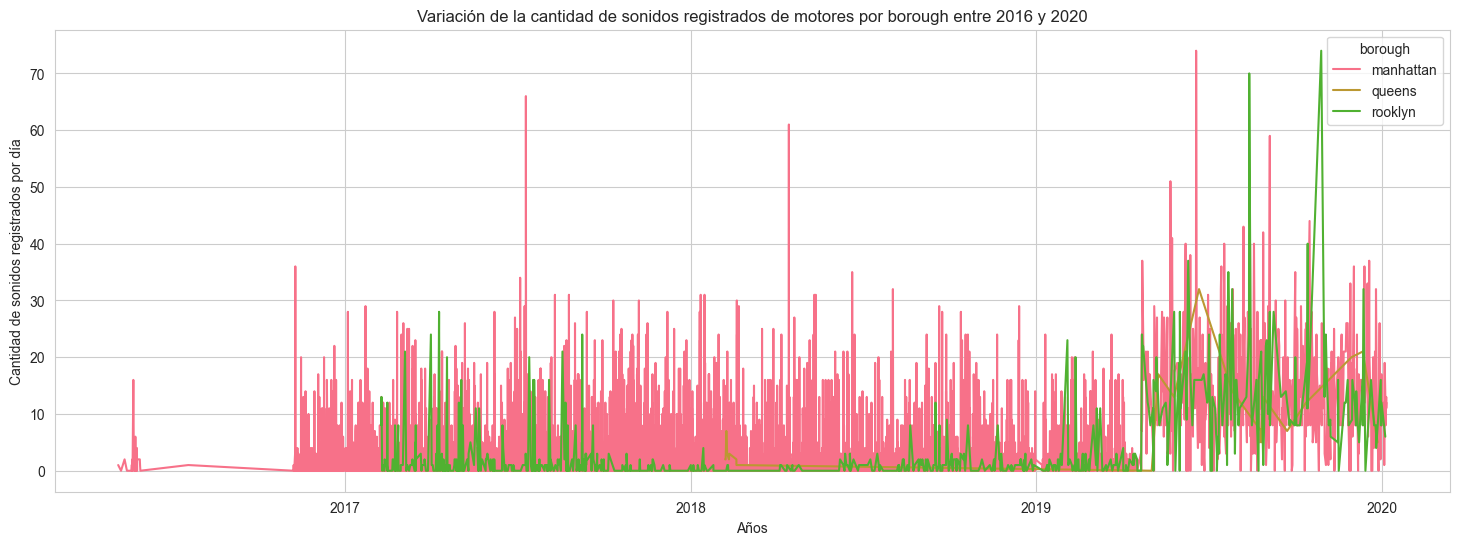

In [100]:
# Definir figura y tamaño
plt.figure(figsize=(18, 6))

# Graficar datos
sns.lineplot(data=noise_pollution_v1.groupby(['borough','date']).sum().reset_index(),
             x='date',
             y='engine_sound_pres',
             hue='borough'
             )

# Formatear eje X
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Titulo del grafico
plt.title(f"Variación de la cantidad de sonidos registrados de motores por borough entre {noise_pollution_v1['date'].dt.year.min()} y {noise_pollution_v1['date'].dt.year.max()}")

# Etiquetas de ejes
plt.xlabel('Años')
plt.ylabel('Cantidad de sonidos registrados por día')

plt.show()

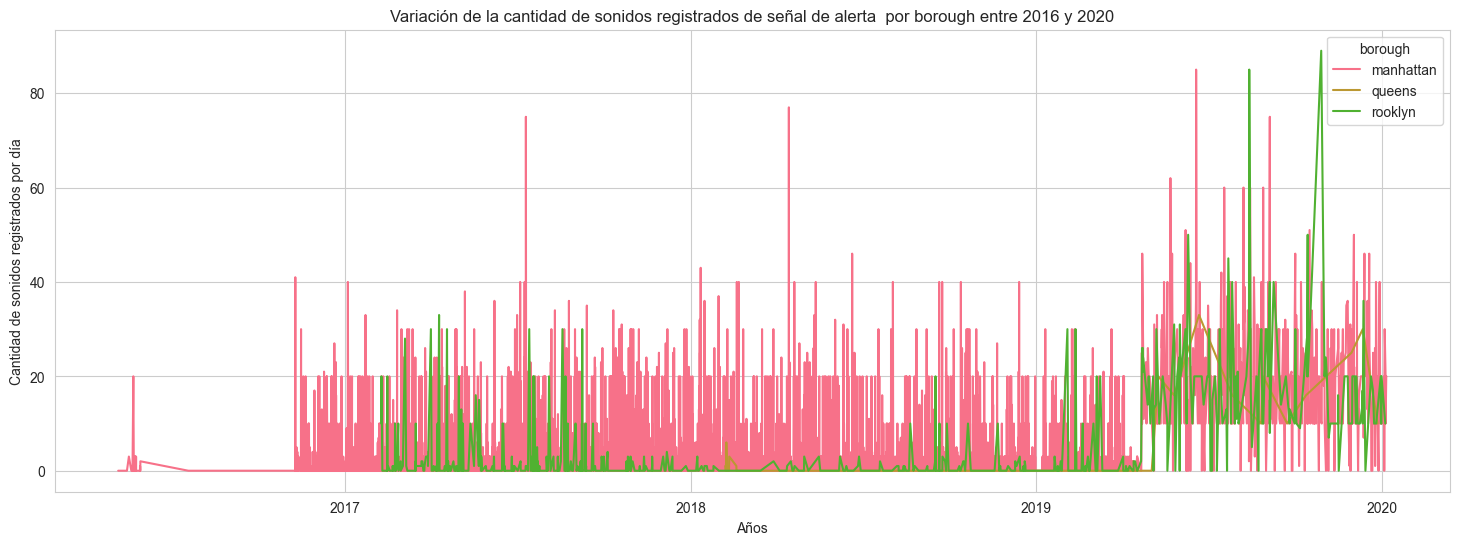

In [101]:
# Definir figura y tamaño
plt.figure(figsize=(18, 6))

# Graficar datos
sns.lineplot(data=noise_pollution_v1.groupby(['borough','date']).sum().reset_index(),
             x='date',
             y='alert_signal_pres',
             hue='borough')

# Formatear eje X
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Titulo del grafico
plt.title(f"Variación de la cantidad de sonidos registrados de señal de alerta  por borough entre {noise_pollution_v1['date'].dt.year.min()} y {noise_pollution_v1['date'].dt.year.max()}")

# Etiquetas de ejes
plt.xlabel('Años')
plt.ylabel('Cantidad de sonidos registrados por día')

plt.show()

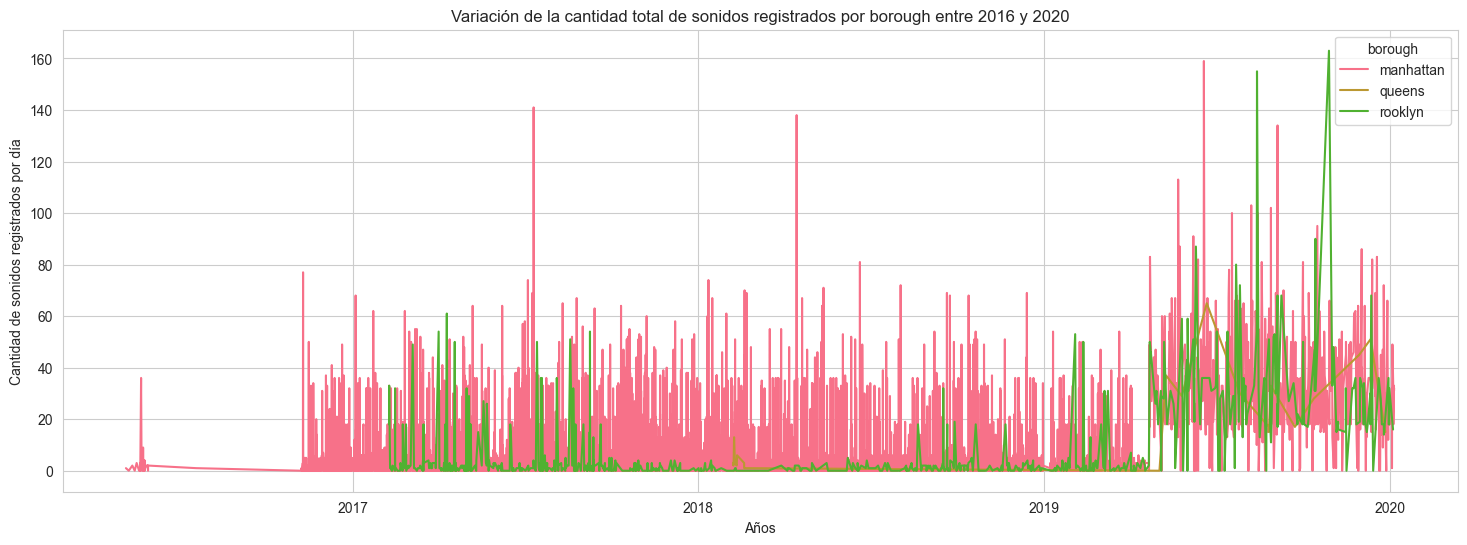

In [102]:
# Definir figura y tamaño
plt.figure(figsize=(18, 6))

# Graficar datos
sns.lineplot(data=noise_pollution_v1.groupby(['borough','date']).sum().reset_index(),
             x='date',
             y='total_sounds_pres',
             hue='borough')

# Formatear eje X
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Titulo del grafico
plt.title(f"Variación de la cantidad total de sonidos registrados por borough entre {noise_pollution_v1['date'].dt.year.min()} y {noise_pollution_v1['date'].dt.year.max()}")

# Etiquetas de ejes
plt.xlabel('Años')
plt.ylabel('Cantidad de sonidos registrados por día')

plt.show()

In [103]:
# Eliminar la variable block, date, hour, latitude, longitude
noise_pollution_v1 = noise_pollution_v1.drop(['block','date', 'hour','latitude','longitude'], axis=1)

In [104]:
# Reordenando las variables
noise_pollution_v1 = noise_pollution_v1.loc[::, ['borough', 'year', 'month', 'week', 'day', 'alert_signal_pres', 'engine_sound_pres','total_sounds_pres']]

In [105]:
# Veamos el dataframe
noise_pollution_v1.head()

,borough,year,month,week,day,alert_signal_pres,engine_sound_pres,total_sounds_pres
0,manhattan,2019,10,43,4,5,4,9
1,manhattan,2019,10,43,4,5,1,6
2,manhattan,2019,10,43,4,5,1,6
3,manhattan,2019,10,43,4,5,4,9
4,manhattan,2019,10,43,4,0,2,2


In [106]:
# Cantidad de sonidos registrados en un determinado Borough proveniente de sonidos de automóviles y señales de alerta cada día.
noise_pollution_v2 = (noise_pollution_v1.groupby(['borough', 'year','month','week','day']).sum().loc[::,'alert_signal_pres':'total_sounds_pres'])
noise_pollution_v2 = noise_pollution_v2.reset_index()

In [107]:
# Funcion que reemplaza: 1: 'manhattan': 1, 'Brooklyn':3 y 'Queens': 4
def replace_id_borough_by_borough(df: pd.DataFrame, colname: str, new_colname: str):
    borough = {
        'manhattan': 1,
        'bronx': 2,
        'rooklyn': 3,
        'queens': 4,
        'staten island': 5,
    }
    df[new_colname] = df[colname].replace(borough)
    return df

In [108]:
# Reemplazo de los nombres de borough por el id correspondiente
noise_pollution_v2 = replace_id_borough_by_borough(noise_pollution_v2, 'borough', 'borough_id')

In [109]:
noise_pollution_v2

,borough,year,month,week,day,alert_signal_pres,engine_sound_pres,total_sounds_pres,borough_id
0,manhattan,2016,1,52,0,7,15,22,1
1,manhattan,2016,5,18,5,0,1,1,1
2,manhattan,2016,5,19,0,0,0,0,1
3,manhattan,2016,5,19,1,0,0,0,1
4,manhattan,2016,5,19,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...
1634,rooklyn,2019,12,50,5,20,16,36,3
1635,rooklyn,2019,12,51,1,10,8,18,3
1636,rooklyn,2019,12,51,3,20,12,32,3
1637,rooklyn,2019,12,52,1,30,24,54,3


## Data Procesada

<h2 align='center'>Table name: noise_pollution</h2>

|    **Columns**    |                                                                                                                            **Description**                                                                                                                           | **type** |
|:-----------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:--------:|
|      borough      | The NYC borough name in which the sensor is located (Manhattan, Brooklyn, Queens).                                                                                                                                                                                   |    str   |
|        year       | The year the recording is from.                                                                                                                                                                                                                                      |    int   |
|       month       | The month of the recording is from, with January as the start (i.e. 1=January).                                                                                                                                                                                      |    int   |
|        week       | The week of the recording if from.                                                                                                                                                                                                                                   |    int   |
|        day        | The day of the week the recording is from, with Monday as the start (i.e. 0=Monday).                                                                                                                                                                                 |    int   |
| engine_sound_pres | Number of recorded sounds coming from a small engine, medium engine, large engine,  or any motor sound in the vehicle whose sound size cannot be accurately determined.                                                                                              |    int   |
| alert_signal_pres | Number of recorded sounds coming from a horn or honk, anti-theft alarm, emergency  vehicle sirens like ambulances and patrol cars, reverse signaling devices, and any  another type of alert signal in the vehicle whose sound size cannot be accurately determined. |    int   |
| total_sounds_pres | Number of recorded sounds coming from alert signals and motors (engine_sound_pres and alert_signal_pres)                                                                                                                                                             |    int   |
|     borough_id    | The NYC borough in which the sensor is located (1=Manhattan, 3=Brooklyn, 4=Queens). This corresponds to the first digit in the 10-digit NYC parcel number system known as Borough, Block, Lot (BBL).                                                                 |    int   |

* **borough**: The NYC borough name in which the sensor is located (Manhattan, Brooklyn, Queens).
* **year**: The year the recording is from.
* **month**: The month of the recording is from, with January as the start (i.e. 1=January).
* **week**: The week of the recording if from. 
* **day**: The day of the week the recording is from, with Monday as the start (i.e. 0=Monday).
* **engine_sound_pres**: Number of recorded sounds coming from a small engine, medium engine, large engine, or any motor sound in the vehicle whose sound size cannot be accurately determined.
* **alert_signal_pres**: Number of recorded sounds coming from a horn or honk, anti-theft alarm, emergency vehicle sirens like ambulances and patrol cars, reverse signaling devices, and any another type of alert signal in the vehicle whose sound size cannot be accurately determined.
* **total_sounds_pres**: Number of recorded sounds coming from alert signals and motors (engine_sound_pres and alert_signal_pres).
* **borough_id**: The NYC borough in which the sensor is located (1=Manhattan, 3=Brooklyn, 4=Queens). This corresponds to the first digit in the 10-digit NYC parcel number system known as Borough, Block, Lot (BBL).

In [123]:
# Exportamos la data procesada
noise_pollution_v2.to_csv(proc_data_dir('noise_pollution.csv'), index=False)

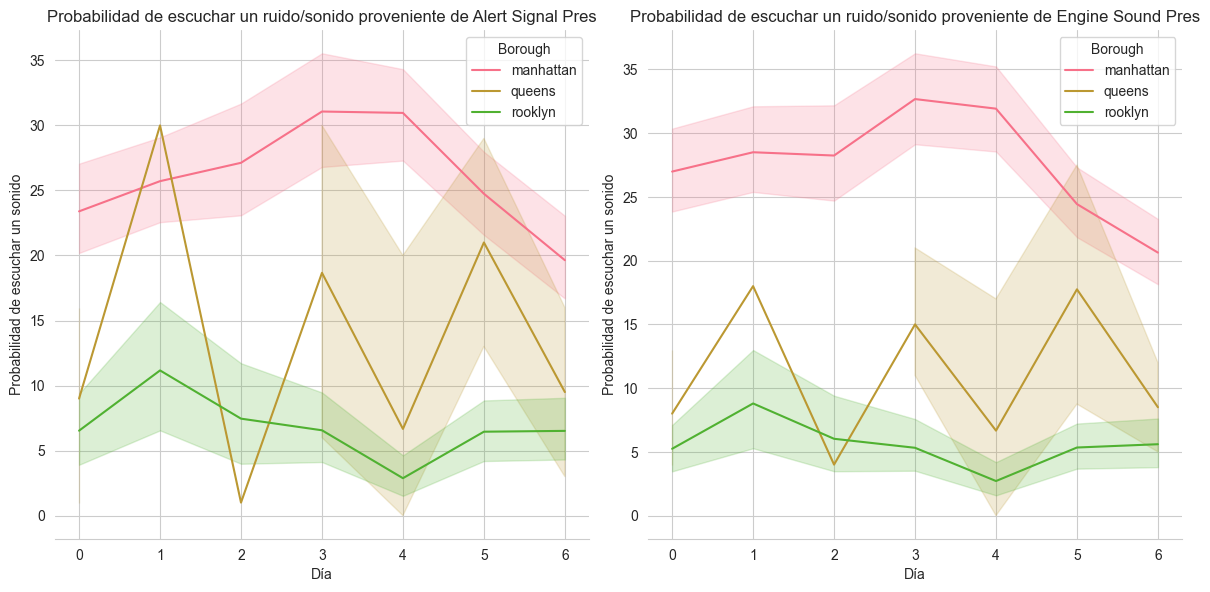

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# definir el número de filas y columnas para organizar las gráficas
num_cols = 2
num_rows = (len(noise_pollution_v2.columns[5:-1]) + 1) // 2

# definir el tamaño de la figura
fig, axs = plt.subplots(ncols=num_cols, figsize=(12,6))

# iterar por cada columna y graficar en un subplot diferente
for i, col in enumerate(noise_pollution_v2.columns[5:-1]):
    # seleccionar el subplot correspondiente
    ax = axs[i % 2]
    
    # crear el gráfico de líneas apiladas
    sns.set_style('whitegrid')
    sns.set_palette('husl')
    sns.lineplot(data=noise_pollution_v2, x='day', y=f'{col}', hue='borough', ax=ax)

    # personalizar el gráfico
    sns.despine(left=True, ax=ax)
    # Probabilidad de escuchar un ruido/sonido en un determinado Borough proveniente de sonidos de automóviles y señales de alerta cada día
    ax.set_title(f"Probabilidad de escuchar un ruido/sonido proveniente de {col.replace('_', ' ').title()}")
    ax.set_xlabel('Día')
    ax.set_ylabel('Probabilidad de escuchar un sonido')
    ax.legend(title='Borough', loc='upper right')

    if i % 2 != 0:
        # ajustar los subplots
        fig.tight_layout(pad=1.0)
        plt.show()

# ajustar los subplots y mostrar la figura
if len(noise_pollution_v2.columns[5:-1]) % 2 == 1:
    axs[-1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

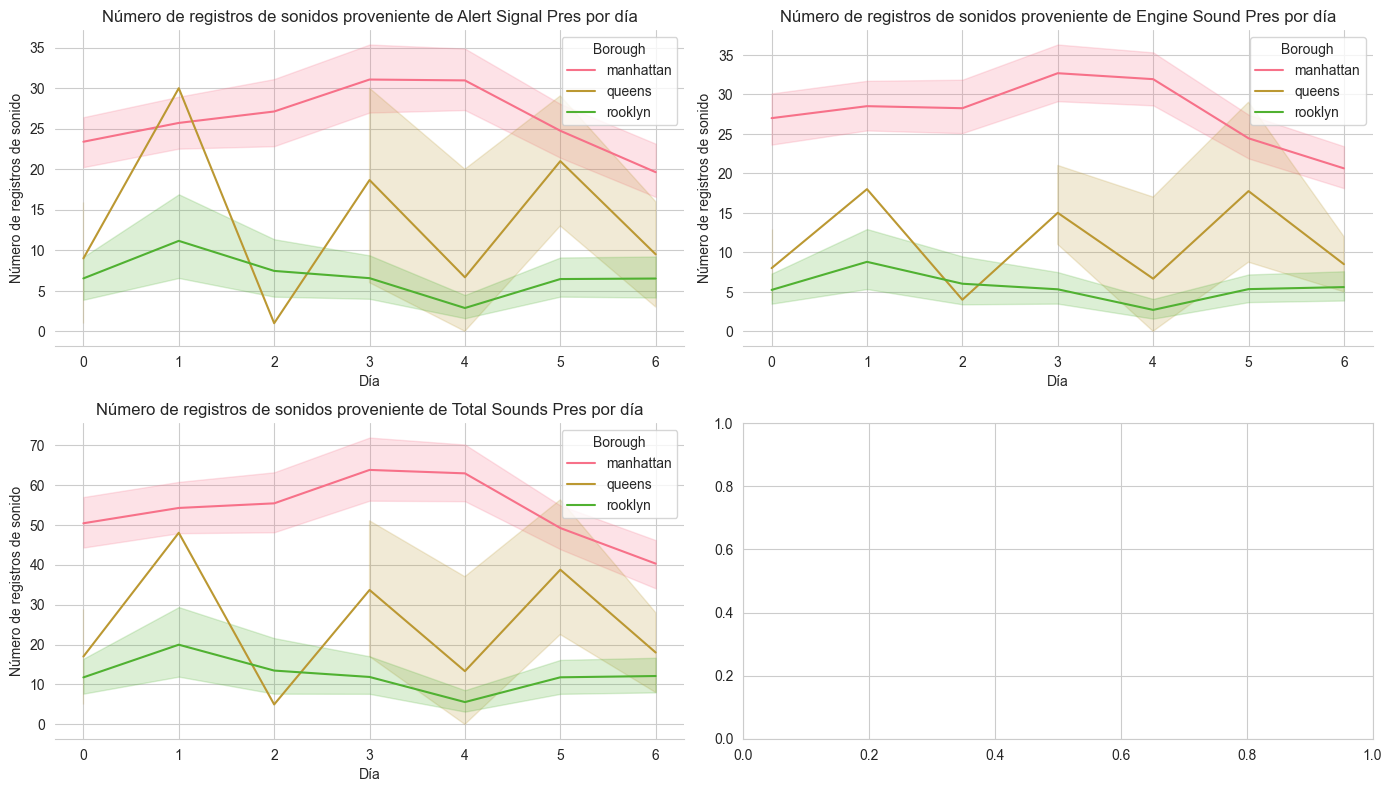

In [137]:
# definir el número de filas y columnas para organizar las gráficas
num_cols = 2
num_rows = (len(noise_pollution_v2.columns[5:-1]) + 1) // 2

# definir el tamaño de la figura
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14,8))

# iterar por cada columna y graficar en un subplot diferente
for i, col in enumerate(noise_pollution_v2.columns[5:-1]):
    # seleccionar el subplot correspondiente
    ax = axs[i // num_cols, i % num_cols]
    
    # crear el gráfico de líneas apiladas
    sns.set_style('whitegrid')
    sns.set_palette('husl')
    sns.lineplot(data=noise_pollution_v2, x='day', y=f'{col}', hue='borough', ax=ax)

    # personalizar el gráfico
    sns.despine(left=True, ax=ax)
    # Probabilidad de escuchar un ruido/sonido en un determinado Borough proveniente de sonidos de automóviles y señales de alerta cada día
    ax.set_title(f"Número de registros de sonidos proveniente de {col.replace('_', ' ').title()} por día")
    ax.set_xlabel('Día')
    ax.set_ylabel('Número de registros de sonido')
    ax.legend(title='Borough', loc='upper right')

# ajustar los subplots y mostrar la figura
fig.tight_layout(pad=1.0)
plt.show()
